# DISCO MUSIC GENERATION WITH VAES
### Required Tools: Tensorflow, Keras, Jupyter Notebook or Google Colab
#### Reference: https://www.kaggle.com/basu369victor/generate-music-with-variational-autoencoder
#### Dataset: https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

# Import Libraries
### Refer to the `README.md` and `requirements.txt` to download the necessary dependencies.

In [1]:
import librosa #librosa for audio processing

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

import music21

AUTOTUNE = tf.data.experimental.AUTOTUNE

### Uncomment the following code if you are using Google Colab

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# Global Variables

In [3]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

train_size = 60000
BATCH_SIZE = 8
test_size = 10000
epochs = 30
latent_dim = 10
num_examples_to_generate = 1

# Data and Loading

In [4]:
def DatasetLoader(class_):
    path = './data/' # For Google Colab, use the path below
    # path = '/content/drive/MyDrive/Final Project (1)/ee435-music-generation-master/data/'
    music_list = np.array(sorted(os.listdir(path + class_)))
    train_music_1 = list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]]) 
    train_music_2 = list(music_list[[4,43,56,55,45,31,11,13,70,37,21,78]]) 
    TrackSet_1 = [path + class_ + '/%s'%(x) for x in train_music_1]
    TrackSet_2 = [path + class_ + '/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

Load file and discretize music with sampling rate = 20000 Hz

In [5]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=20000, offset=0.0, duration=10)
    data_ = data_.reshape(1,200000)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [6]:
TrackSet_1, TrackSet_2 = DatasetLoader('disco')

Example Track

In [7]:
sample = TrackSet_1[5]
print(sample)
sample_, sampling_rate = librosa.load(sample, sr=20000, offset=0.0, duration=10)
ipd.Audio(sample_,rate=20000)

./data/disco/disco.00012.wav


Example Waveplots

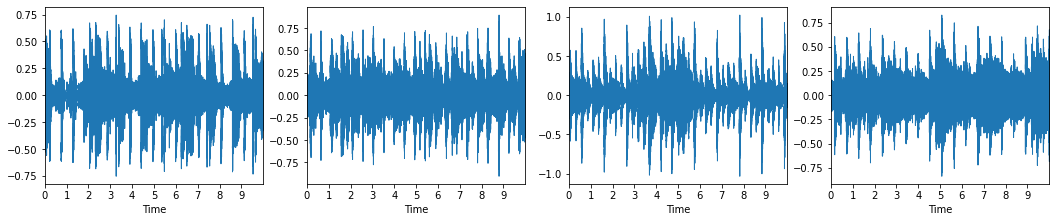

In [8]:
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    librosa.display.waveplot(j[0], sr=20000)

Define Train and Testing Datasets

In [9]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


# Network Architecture

High Level Overview of VAE:

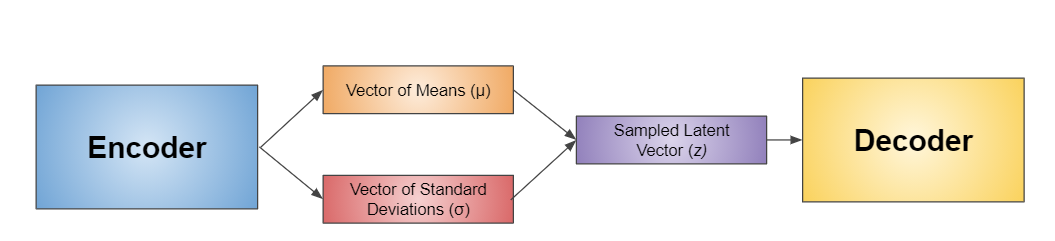

Define Residual Block

In [10]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__(name='')
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor    #skip connection
        return tf.nn.relu(x)

Defining Convolutional Variational Autoencoder (https://arxiv.org/pdf/2005.00341.pdf and https://arxiv.org/pdf/1711.00937.pdf)

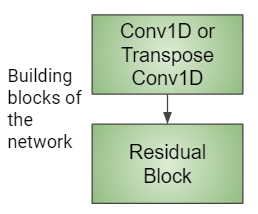

Reparameterization Function included in CVAE class

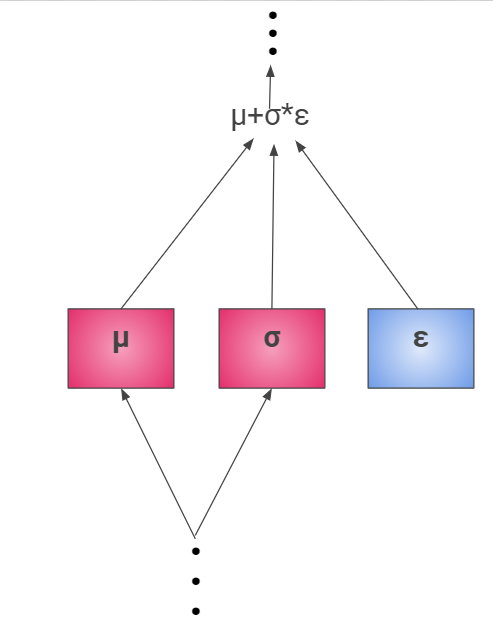

In [11]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,200000)),
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                layers.Flatten(),
                layers.Dense(latent_dim + latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                layers.Conv1DTranspose(200000,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

ADAM Optimizer

In [12]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

#Defining Loss Functions and Helper Function for Loss

In [13]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

Reconstruction Loss is Sigmoid Cross Entropy. Latent Space Regularization through KL Divergence 

In [14]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

Latent space regularization through KL divergence allows for densely packed, continuous latent representation with distinct clusters. 

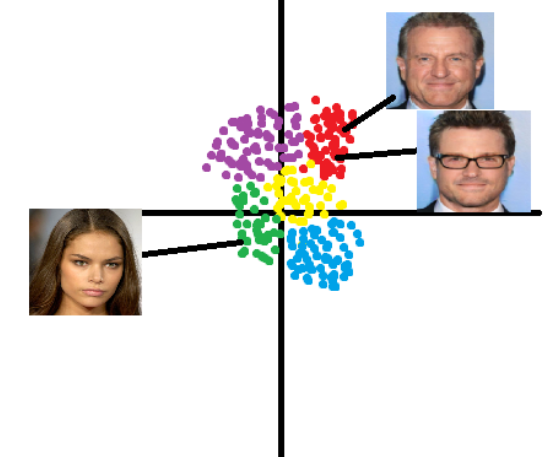

#Define Training Functions

In [15]:
@tf.function
def train_step(model, x, optimizer):
    
    """One training step + return the loss"""
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss + loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [16]:
#constant random noise vector
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [17]:
import librosa.display
save_music=[]
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        if epoch>14:
            save_music.append(wave)
        librosa.display.waveplot(wave[0], sr=20000)
    
    savefigpath = '' # For Google Colab, use the path below to save the figure
    # savefigpath = '/content/drive/MyDrive/Final Project (1)/ee435-music-generation-master/'
    plt.savefig(savefigpath + './plot/disco_{:04d}.png'.format(epoch))
    plt.show()

In [18]:
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

Epoch: 30, Test set ELBO: 805841.125, time elapse for current epoch: 0.741523027420044


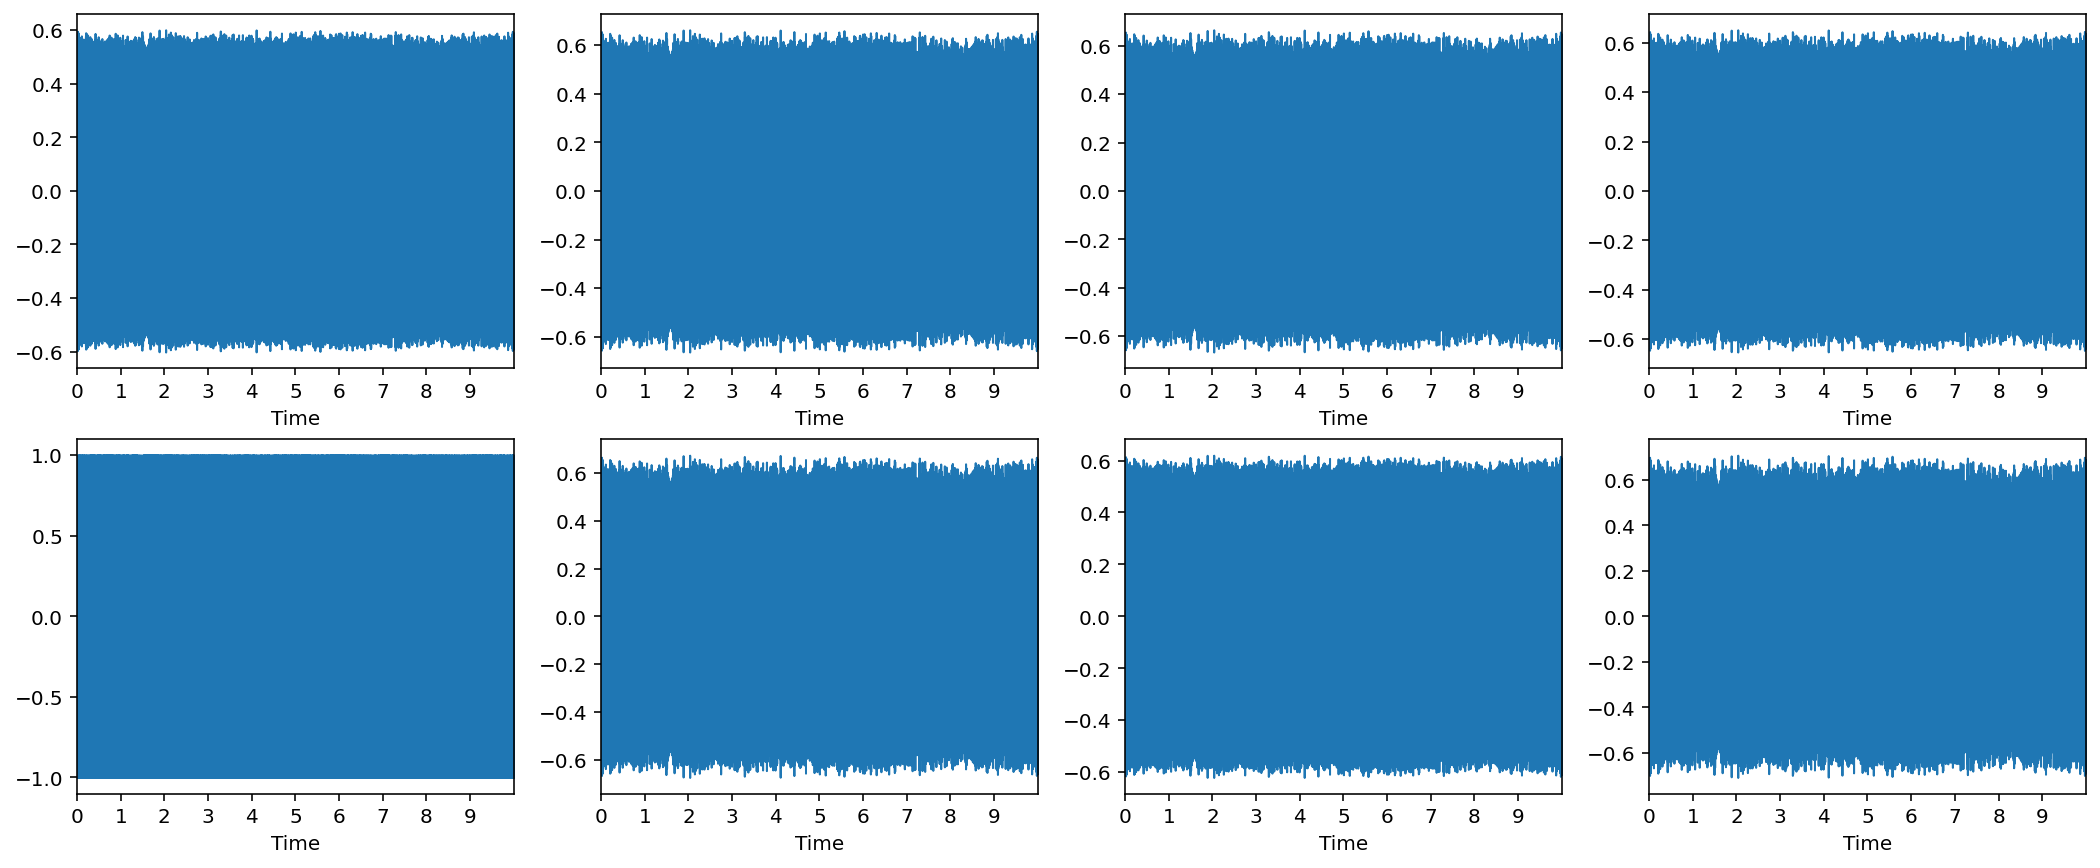

In [19]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_x = np.asarray(train_x)[0]
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        test_x = np.asarray(test_x)[0]
        loss(compute_loss(model, test_x))
    display.clear_output(wait=False)
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

Training Animation

In [20]:
savefigpath = '.' # For Google Colab, use the path below to save the figure
# savefigpath = '/content/drive/MyDrive/Final Project (1)/ee435-music-generation-master/'

anim_file_1 = savefigpath+'/plot/disco_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob(savefigpath+'/plot/disco*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


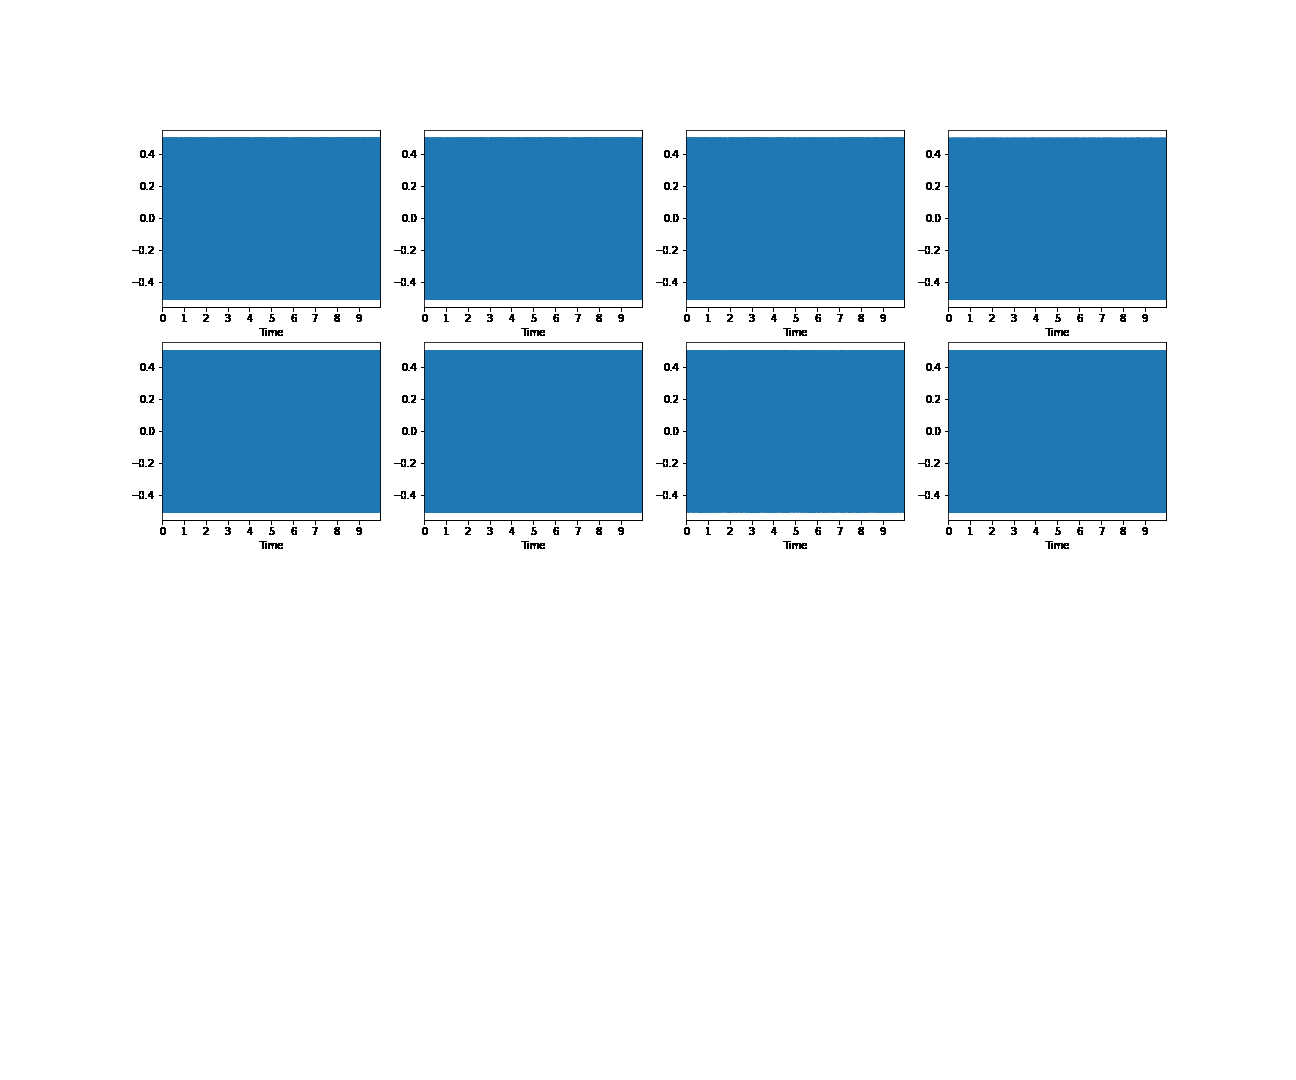

In [21]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)

#Sample Music

In [22]:
l1=save_music[127][0]
ipd.Audio(l1,rate=20000)